In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# lists possible devices (CPU, GPU)
# used to check if GPU is recognized/exists
tf.config.get_visible_devices()


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10109139263121305168
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5677594720
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3458120873507093730
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# preprocessing of the images applied when loading image data set from disk with
# tensorflows flow_from_directory

image_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,  # rotate the image 20 degrees
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255,  # Rescale the image by normalzing it.
                                                         shear_range=0.15,
                                                         # Shear means cutting away part of the image (max 20%)
                                                         zoom_range=0.15,  # Zoom in by 15% max
                                                         horizontal_flip=True,  # Allow horizontal flipping
                                                         fill_mode='nearest'
                                                         # Fill in missing pixels with the nearest filled value
                                                         )

In [4]:
# path to the image data set

#train_data_path = './drive/MyDrive/Bachelor/data_balanced/train' #google colab
#test_data_path = './drive/MyDrive/Bachelor/data_balanced/test' #google colab
#validation_data_path = './drive/MyDrive/Bachelor/data_balanced/validation' #google colab
train_data_path = './data/test-bed-deffects/data_balanced/train'  #local notebook
test_data_path = './data/test-bed-deffects/data_balanced/test'  #local notebook
validation_data_path = './data/test-bed-deffects/data_balanced/validation'  #local notebook


In [5]:
# generate training set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {train} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

train_image_gen = image_gen.flow_from_directory(train_data_path,
                                                target_size=(180, 180),
                                                class_mode='binary')

Found 2000 images belonging to 2 classes.


In [6]:
# generate test set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {test} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

test_image_gen = image_gen.flow_from_directory(test_data_path,
                                               target_size=(180, 180),
                                               class_mode='binary')

Found 998 images belonging to 2 classes.


In [7]:
# generate validation set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {validation} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

valid_set = image_gen.flow_from_directory(validation_data_path,
                                          target_size=(180, 180),
                                          class_mode='binary')

Found 1000 images belonging to 2 classes.


In [8]:
# saves the model and its weights as a json file in the folder saved_models

def save_model(model, model_name):
    my_model = model.to_json()
    with open(f'./saved_models/{model_name}.json', "w") as file:
        file.write(my_model)
    # serialize weights to HDF5
    model.save_weights(f'./saved_model/{model_name}_weights.h5')

In [ ]:
#TODO: load model no compiling ?

def load_model(model_path, weight_path):
    # load json and create model
    file = open(model_path, 'r')
    model_json = file.read()
    file.close()
    loaded_model = keras.models.model_from_json(model_json)
    # load weights
    loaded_model.load_weights(weight_path)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
    loaded_model.compile(loss="binary_crossentropy", optimizer=optimizer,
                         metrics=['accuracy', 'Recall', 'Precision', 'AUC'])
    return loaded_model

In [9]:
# method to select the base model architecture
# pretrained with the weights of the imagenet data set
# the top layers are excluded and have to be implemented on top of the base model
# currently Vgg16, Xception, ResNet50

def build_base_model(model_selected):
    if model_selected == 'vgg':
        return keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
    if model_selected == 'xception':
        return keras.applications.xception.Xception(include_top=False, weights='imagenet')
    if model_selected == 'resnet':
        return keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')

In [10]:
# method which adds the new top layers on the base model and returns the now complete model

def model_builder(input_model):
    model_input = keras.Input(shape=(180, 180, 3), name='image_input')

    output_base_model = input_model(model_input)

    x = keras.layers.Flatten(name='flatten')(output_base_model)
    x = keras.layers.Dense(1000)(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(1, activation='sigmoid')(x)

    return keras.models.Model(model_input, x)

In [11]:
# method activate the base models layers ability to learn (be trainable)
# set to false for the first training run to not destroy the pretrained weights

def set_layers_trainable(trainable, input_model):
    for layer in input_model.layers:
        layer.trainable = trainable

In [12]:
# method to compile the model with the adam optimizer which returns the compiled model

def compile_model(input_model, alpha, beta1, beta2, metrics):
    optimizer = keras.optimizers.Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2)
    model = model_builder(input_model)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

    return model

In [20]:
# method to train the model

def train_model(input_model, train_set, test_set, epochs, callback):
    return input_model.fit(train_set,
                     validation_data=test_set,
                     epochs=epochs,
                     callbacks=callback)


In [21]:
# Script which uses
# vgg16 as a base model
# the adams optimizer with learning rate: 0.0001, beta_1: 0.9 and beta_2: 0.99
# accuracy, recall, precision, auc as metrics
# trains the frozen model for 5 epochs
# defines an early stopping callback with an patience of 20
# trains the unfrozen model (for 100 epoch) till early stopping stops the training
# and prints the values of the metrics


# set base model
vgg16_base_model = build_base_model('vgg')

# freeze layers of base model for first train run
set_layers_trainable(False, vgg16_base_model)

# compile model (also builds the model)
vgg16_model = compile_model(vgg16_base_model,0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# train frozen layer model
history = train_model(vgg16_model, train_image_gen, test_image_gen, 5, [])

# unfreeze base model layers
set_layers_trainable(True, vgg16_base_model)

# compile model
vgg16_model = compile_model(vgg16_base_model,0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# define callback
custom_early_stopping = keras.callbacks.EarlyStopping(patience=20)

# train complete model
history = train_model(vgg16_model, train_image_gen, test_image_gen, 100, [custom_early_stopping])

# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, accuracy, recall, precision, auc = vgg16_model.evaluate(valid_set)

# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")

Epoch 1/5


NotFoundError: 2 root error(s) found.
  (0) Not found:  No algorithm worked!
	 [[node model_5/vgg16/block1_conv1/Relu (defined at <ipython-input-20-12f6f2a42bd2>:7) ]]
  (1) Not found:  No algorithm worked!
	 [[node model_5/vgg16/block1_conv1/Relu (defined at <ipython-input-20-12f6f2a42bd2>:7) ]]
	 [[assert_greater_equal_2/All/_16]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_34337]

Function call stack:
train_function -> train_function


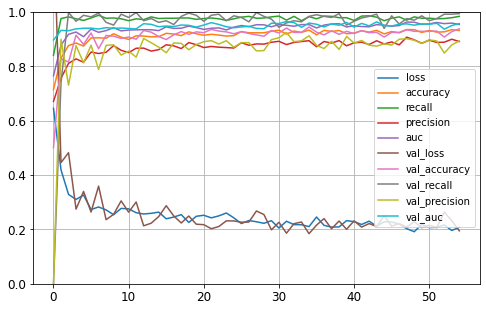

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
plt.show()


In [ ]:
# uses the save_model method to save the model and its weights to the hard drive

save_model(vgg16_model, 'vgg16_v1')
